              Open         High          Low        Close        Volume  \
count  1692.000000  1692.000000  1692.000000  1692.000000  1.692000e+03   
mean    132.441572   134.769698   129.996223   132.428658  4.270741e+06   
std      94.309923    95.694914    92.855227    94.313187  4.295971e+06   
min      16.139999    16.629999    14.980000    15.800000  1.185000e+05   
25%      30.000000    30.650000    29.215000    29.884999  1.194350e+06   
50%     156.334999   162.370002   153.150002   158.160004  3.180700e+06   
75%     220.557495   224.099999   217.119999   220.022503  5.662100e+06   
max     287.670013   291.420013   280.399994   286.040009  3.716390e+07   

         Adj Close  
count  1692.000000  
mean    132.428658  
std      94.313187  
min      15.800000  
25%      29.884999  
50%     158.160004  
75%     220.022503  
max     286.040009  


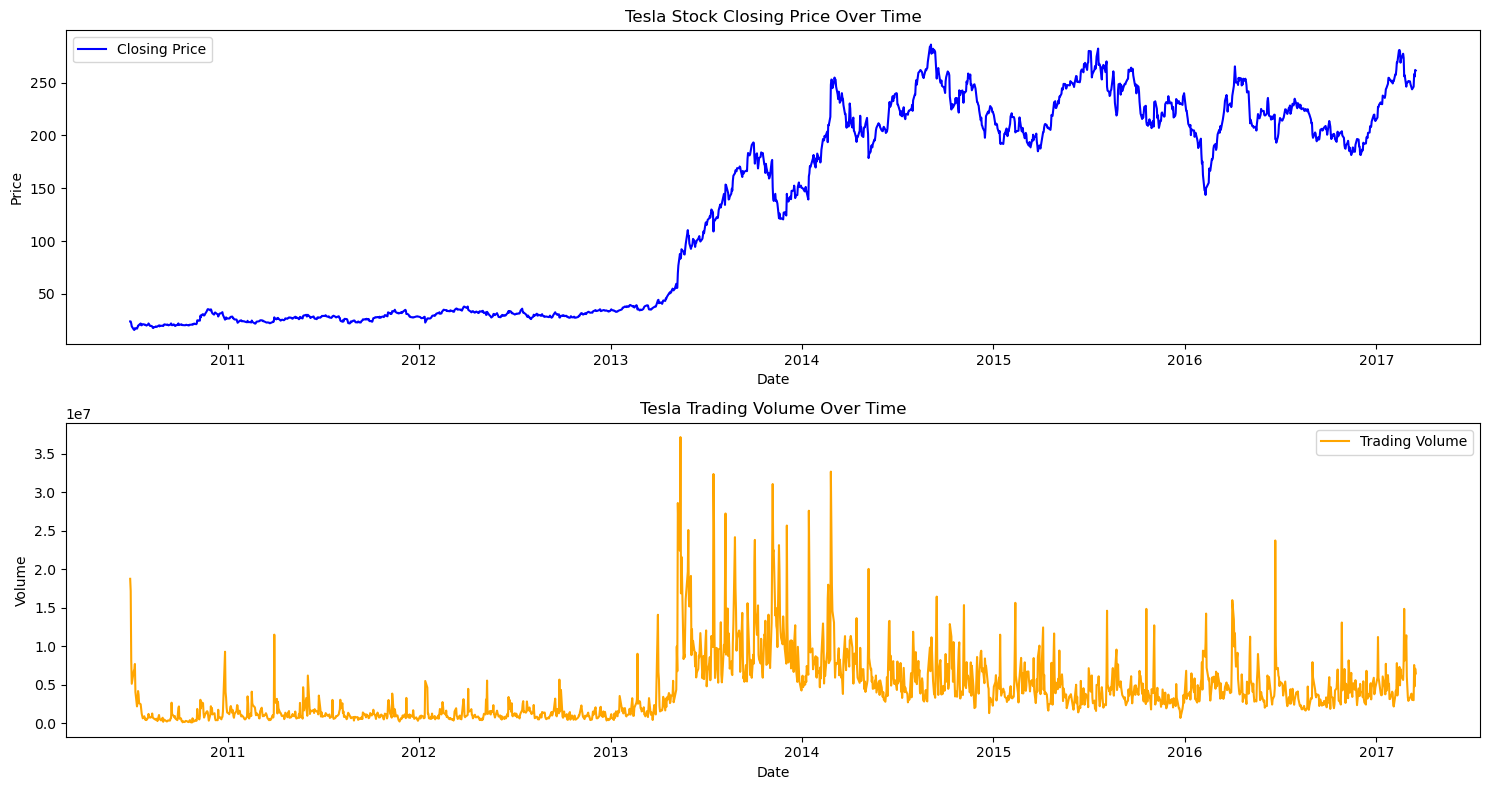

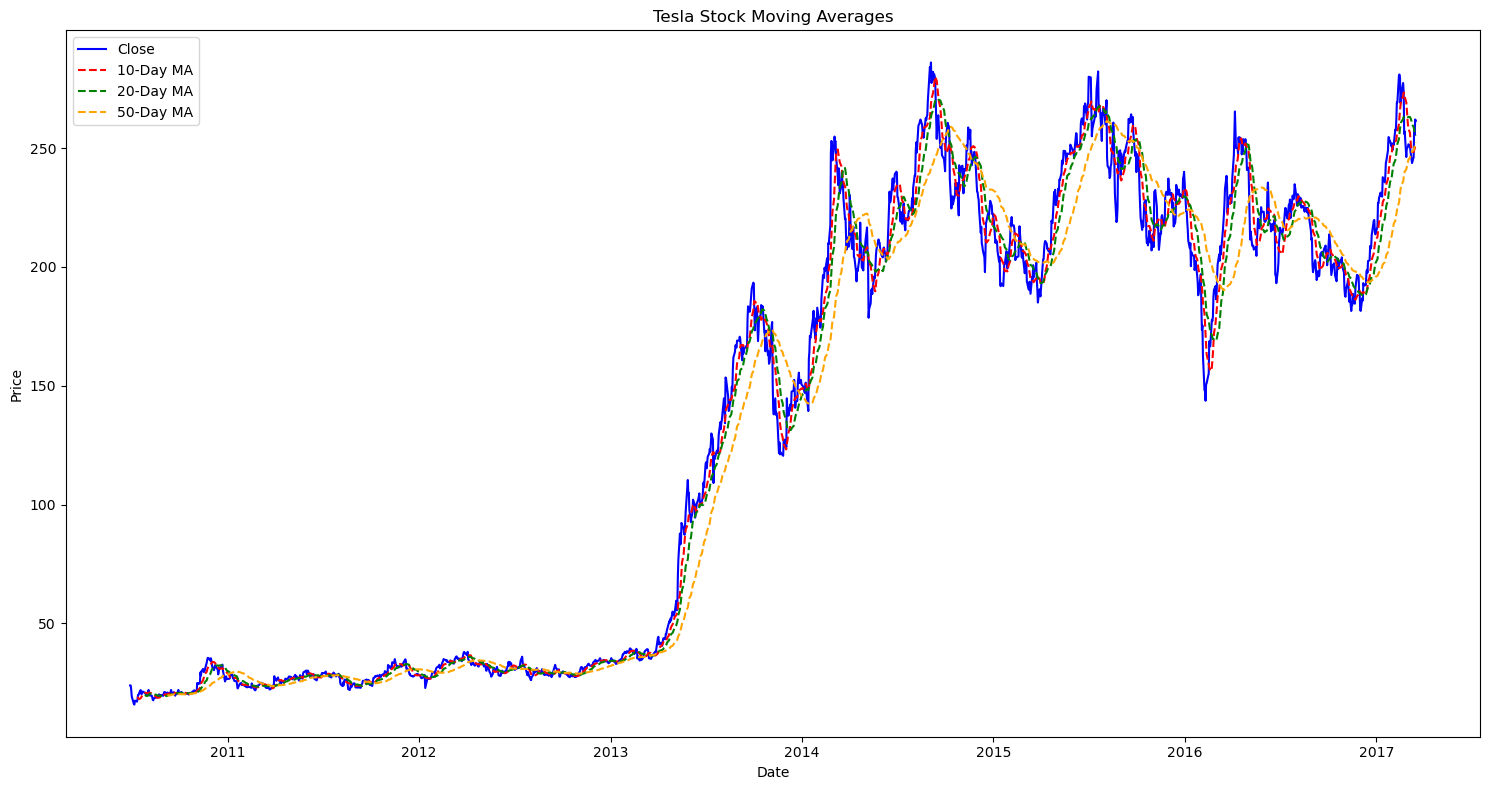

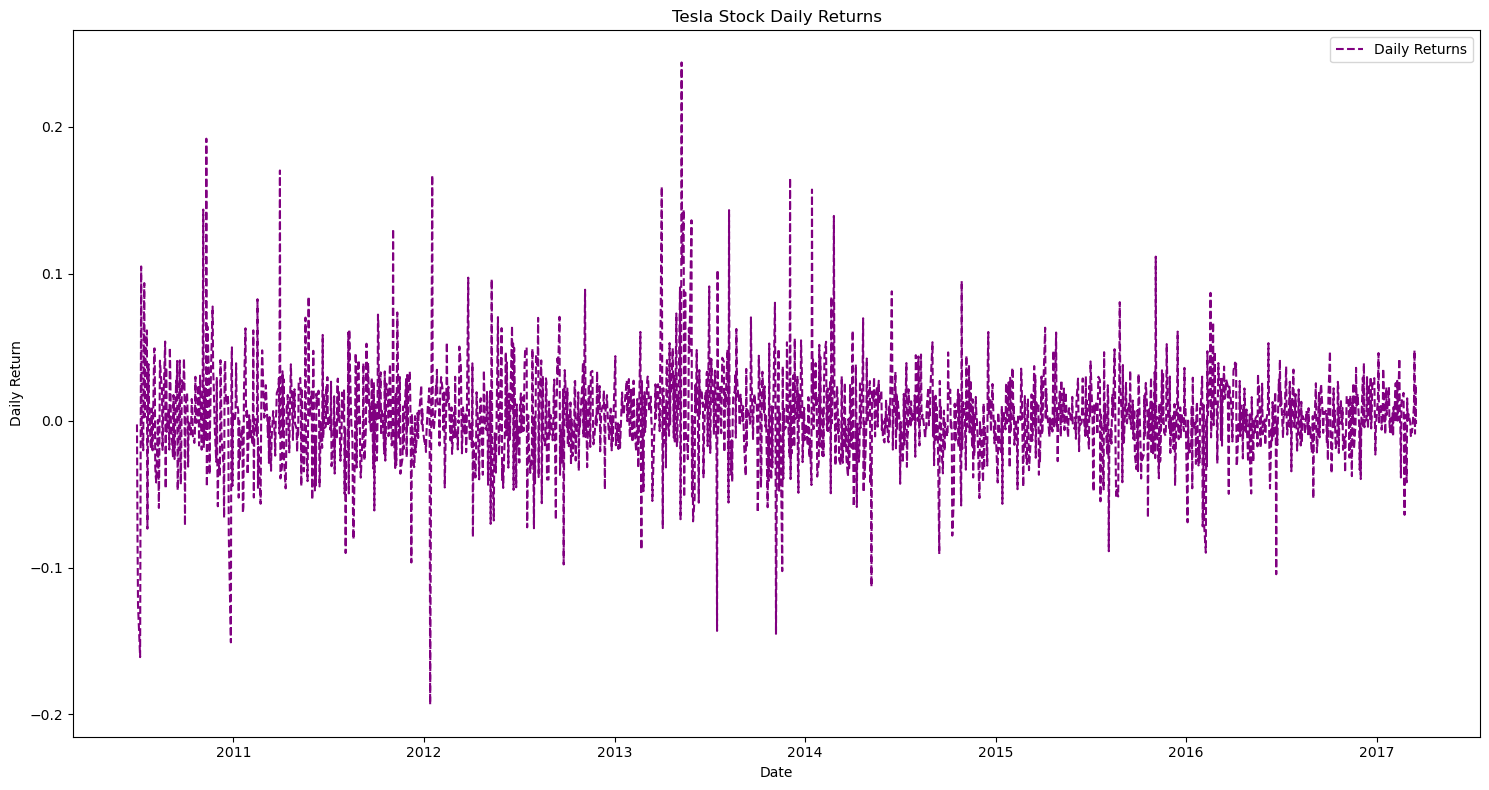

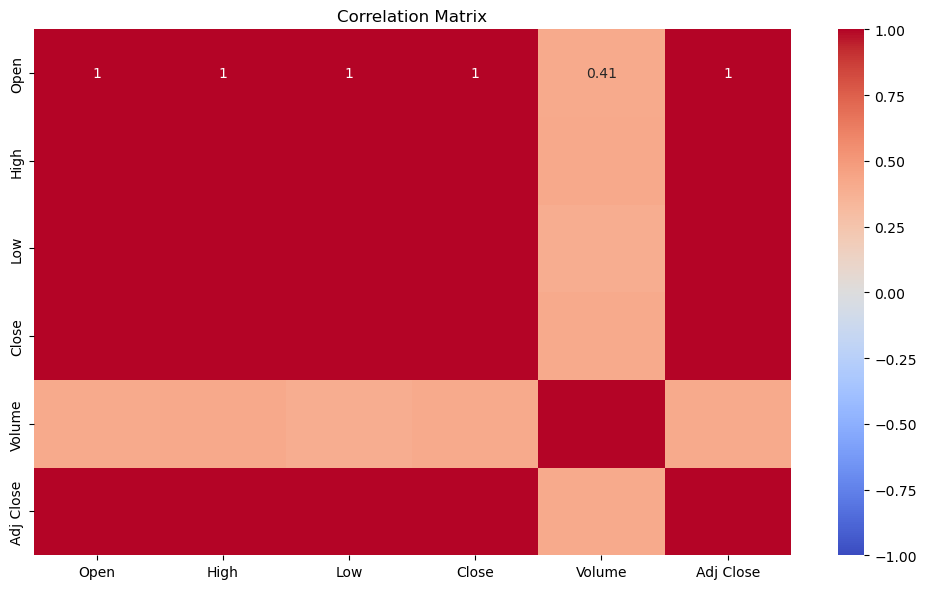

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1293/1293 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0113
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/var/folders/jp/1xvfy4sx74ncyqym7k1ncbn80000gn/T/ipykernel_96860/1686594059.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


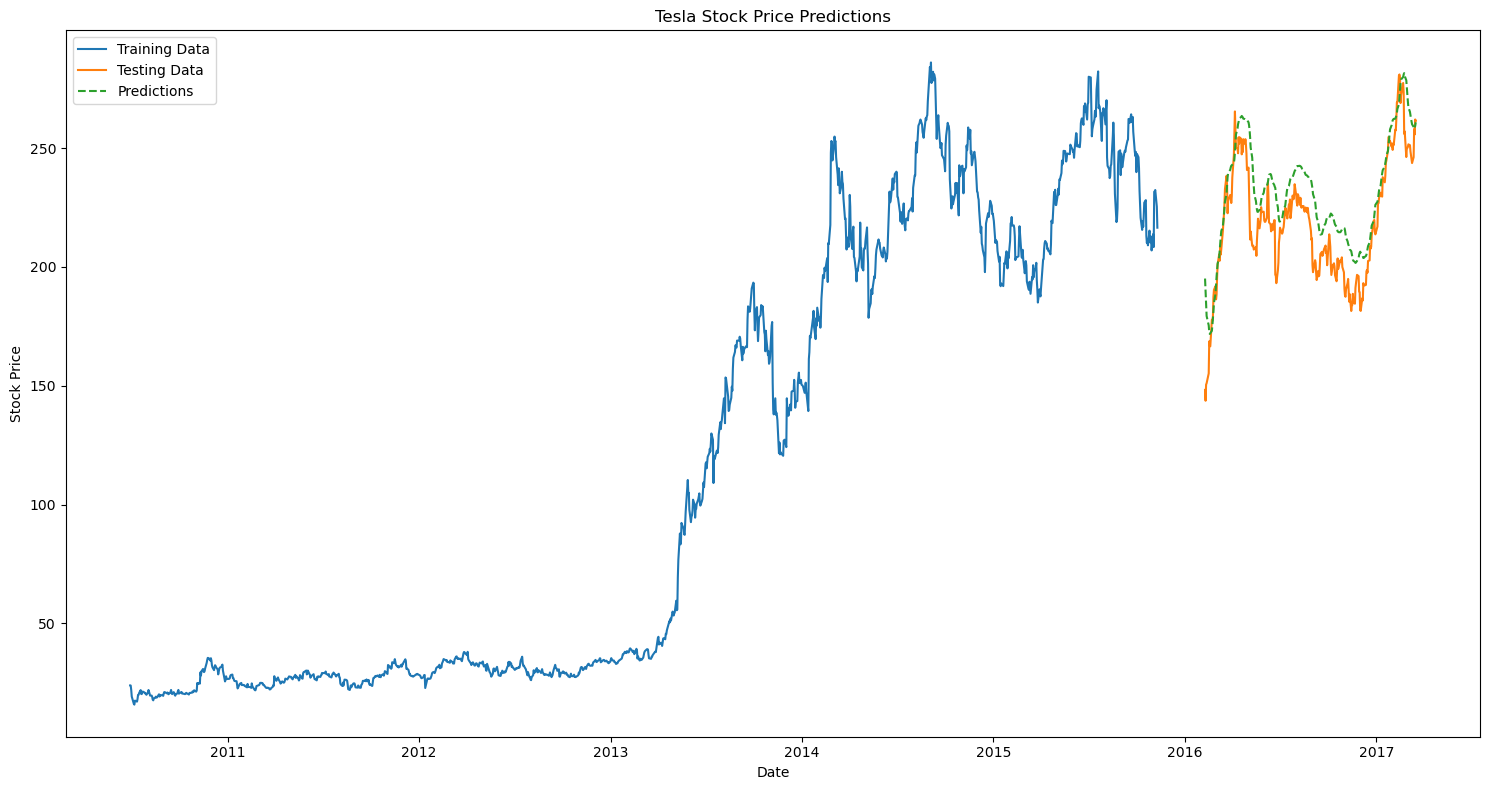

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load Tesla stock data
tesla_data = pd.read_csv("/Users/pranup/Downloads/Tesla.csv")
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

# Summary statistics and visualization
print(tesla_data.describe())

# Plot Closing Price and Volume
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(tesla_data['Close'], label='Closing Price', color='blue')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tesla_data['Volume'], label='Trading Volume', color='orange')
plt.title('Tesla Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.tight_layout()
plt.show()

# Moving averages (10, 20, 50-day)
for ma in [10, 20, 50]:
    tesla_data[f'MA_{ma}'] = tesla_data['Close'].rolling(window=ma).mean()

plt.figure(figsize=(15, 8))
plt.plot(tesla_data['Close'], label='Close', color='blue')
plt.plot(tesla_data['MA_10'], label='10-Day MA', color='red', linestyle='--')
plt.plot(tesla_data['MA_20'], label='20-Day MA', color='green', linestyle='--')
plt.plot(tesla_data['MA_50'], label='50-Day MA', color='orange', linestyle='--')
plt.title('Tesla Stock Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate daily returns
tesla_data['Daily_Return'] = tesla_data['Adj Close'].pct_change()

plt.figure(figsize=(15, 8))
plt.plot(tesla_data['Daily_Return'], label='Daily Returns', color='purple', linestyle='--')
plt.title('Tesla Stock Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = tesla_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# LSTM Model Preparation
data = tesla_data[['Adj Close']].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data)
x_test, y_test = create_dataset(test_data)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Align the valid DataFrame with predictions
train = tesla_data[:train_size]
valid = tesla_data[train_size + 60:]  # Start from 60 rows into the test set
valid['Predictions'] = predictions

# Visualize Predictions
plt.figure(figsize=(15, 8))
plt.plot(train['Adj Close'], label='Training Data')
plt.plot(valid['Adj Close'], label='Testing Data')
plt.plot(valid['Predictions'], label='Predictions', linestyle='--')
plt.title('Tesla Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()
